In [ ]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from utils import *
from tgp_research_quantitative_tools.optionpricing.ClosedForm.Black import SpreadOptionTwoAssets

###  First, we set the details of our HRCO

In [ ]:
as_of = dt.datetime(2024, 2, 10) # date of reference fwd curve

start_simulation_date = dt.datetime(2024, 5, 29)
end_simulation_date = dt.datetime(2024, 9, 2)

start_contract_date = dt.datetime(2024, 6, 1)
end_contract_date = dt.datetime(2024, 8, 30)

power_market = "ERCOTHOUHUB"
gas_market = "HH_gas"

granularity = "daily"
methodology = "spot" # we use spot simulations since we need the 1-day ahead prices

heat_rate = 12 # MMBtu/MWh
gas_adder = 0.05 # $/MMBtu
start_charge = 700 # MMBtu (to be multiplied by the gas price)
VOM = 0.8 # $/MWh
daily_volume = 24 * 200 # MWh

energy_payment_delay = 20 # days from delivery to payment date
energy_payment_grouped_monthly = True # True if Energy Payments are group by month, False otherwise 

monthly_option_premium = 5e6 # $/month
# The buyer pays option premiums from the first simulated day up to the last day of the contract
option_premium_payment_dates = pd.date_range(
    start=start_simulation_date.replace(day=1) + pd.DateOffset(months=1),
    end=end_contract_date,
    freq='MS'
)
# Prepend the capped start date
option_premium_payment_dates = pd.DatetimeIndex([start_simulation_date]).append(option_premium_payment_dates)

# Note that we simplify the pricing by assuming that the buyer of the HRCO only books slots of 24h each day.
# This follows the reasoning that if the MtM is positive, he will make the most out of it by booking the maximum daily amount available.

nb_scenarios = 5000
interest_rate = 0.0425

In [ ]:
option_premium_payment_dates

DatetimeIndex(['2024-05-29', '2024-06-01', '2024-07-01', '2024-08-01'], dtype='datetime64[ns]', freq=None)

### Simulate spot prices for gas and power

In [ ]:
simulation = simulate_fwd_prices(
    [power_market, gas_market], 
    start_simulation_date,
    end_simulation_date, 
    methodology,
    granularity, 
    as_of=as_of, 
    start_fwd_date=start_contract_date,
    nb_simulation=nb_scenarios,
)

c:\Users\AMIREL\Desktop\repos\HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp2 = pd.concat([df_temp, df_temp.shift(1)], axis=1).fillna(method='bfill')
c:\Users\AMIREL\Desktop\repos\HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp2 = pd.concat([df_temp, df_temp.shift(1)], axis=1).fillna(method='bfill')
c:\Users\AMIREL\Desktop\repos\HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp

Time for solve_minimization_problem : 0.08 seconds


c:\Users\AMIREL\Desktop\repos\HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp2 = pd.concat([df_temp, df_temp.shift(1)], axis=1).fillna(method='bfill')
c:\Users\AMIREL\Desktop\repos\HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp2 = pd.concat([df_temp, df_temp.shift(1)], axis=1).fillna(method='bfill')
c:\Users\AMIREL\Desktop\repos\HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.288551749407879e-05
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9
Time for solve_minimization_problem : 0.06 seconds
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0032772687396059015
            Iterations: 51
            Function evaluations: 1019
            Gradient evaluations: 51
Time for solve_minimization_problem : 0.13 seconds


c:\Users\AMIREL\Desktop\repos\HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\DiffusionProcess.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.hourly_index_date_range = pd.date_range(self.start_date, self.end_date + dt.timedelta(days=1),


Time for compute_daily_gas_shaping_from_monthly_assessments : 0.01 seconds


## HRCO Pricing

Build some dfs that we need

In [ ]:
simulation_dates = pd.date_range(start=start_simulation_date, end=end_simulation_date, freq='D')
maturity_dates = simulation_dates.to_frame()[start_contract_date:end_contract_date].index

power_prices_df = pd.DataFrame(simulation[power_market].values, index=simulation_dates)
gas_prices_df = pd.DataFrame(simulation[gas_market].values, index=simulation_dates)

We need to compute *annualized* correlations and volatilities, we will use the average sample variance and correlations from the simulations

In [ ]:
# Volatilities and correlations are computed on the relative daily returns
power_returns_df = power_prices_df.pct_change().dropna()
gas_returns_df = gas_prices_df.pct_change().dropna()

# Compute daily volatilities and annualize them (we use natural years instead of business years since commodities are traded OTC every day)
power_vol = power_returns_df.std(axis=0).mean() * np.sqrt(365.25)
gas_vol = gas_returns_df.std(axis=0).mean() * np.sqrt(365.25)

power_gas_corr = 0

for i in range(nb_scenarios):
    power_gas_corr += np.corrcoef(power_returns_df[i], gas_returns_df[i])[0,1]
    
# Divide to get the average
power_gas_corr /= nb_scenarios

Now we set the coefficients of the HRCO to make it fit the Two-Asset spread option framework. For this, recall that the payoff of our HRCO follows:

$$
P =  \max \bigr\{DV \times S_e - e^{-r \delta_t} \times[DV \times \{HR \times (S_g + GA) + VOM\} + SC \times (S_g + GA)], 0 \bigr\}
$$

Where
- $DV$ is the daily volume (in MWh),
- $S_e$ is the 1-day ahead (spot) electricity price for 24 hours of delivery (in $/MWh),
- $S_g$ is the 1-day ahead (spot) gas price for 24 hours of delivery (in $/MMBtu),
- $\delta_t$ is the time difference between the Energy Payment date and the delivery date (in years), 
- $HR$ is the Heat Ratio (in MMBTu/MWh),
- $GA$ is the gas adder (in $/MMBtu),
- $VOM$ is the Variable Operational and Maintenance costs (in $/MWh),
- $SC$ is the Start Cost (in MMBtu).

Linking to HRCO terminology, we have that

- $(HR \times (S_g + GA) + VOM)$ is the Energy Payment,
- $e^{-r \delta_t} \times (HR \times (S_g + GA) + VOM)$ is the Energy Payment adjusted by the fact that the payment is made $\delta_t$ days after delivery,
- $S_e - e^{-r \delta_t} \times (HR \times (S_g + GA) + VOM)$ is the Spark Spread.

Moreover, a general payoff profile for a Two-Asset Spread Option is of the form:

$$
P = \max \bigr[\alpha \times S_e - \beta \times S_g - K, 0 \bigr]
$$

And therefore, linking both, we have:

$$
\alpha = DV, \\
\beta = e^{-r \delta_t} \times (DV \times HR + SC), \\ 
K = e^{-r \delta_t} \times [DV \times (HR \times GA + VOM) + SC \times GA]
$$

In [ ]:
# PREVIOUS APPROACH USING THE PRICER FROM THE LIBRARY. WE DON'T USE IT SINCE IT IS REALLY SLOW AND WE HAVE DECIDED TO SELECT THE PART THAT WE NEED FROM IT AND PASTE IT HERE.
# MOREOVER, WITH THIS WE CAN VECTORIZE OVER ALL THE SCENARIOS
# I CHECKED THAT IT GIVES THE SAME RESULTS AS THE LIBRARY, BUT IT IS WAY FASTER

# simulation_prices_list = []
# simulation_spark_spreads_list = []
# for i, simul_date in enumerate(simulation_dates):
    
#     maturity_prices_list = []
#     maturity_spark_spreads_list = []
#     for j, maturity_date in enumerate(maturity_dates):
        
#         # Compute delta_t in years (time difference between the Energy Payment date and delivery), taking into account the 1-day delivery delay
#         if energy_payment_grouped_monthly:
#             days_to_end_month = ((maturity_date + pd.offsets.MonthEnd(0)) - maturity_date).days
#             delta_t = (days_to_end_month + energy_payment_delay - 1) / 365.25
#         else:
#             delta_t = (energy_payment_delay - 1) / 365.25
            
#         # Compute time to expiry of the current option (in years), taking into account the 1-day delivery delay
#         time_to_expiry = ((maturity_date - simul_date).days + 1) / 365.25
        
#         # Compute the coefficients for the HRCO option
#         # Note that, since delta_t is not constant but rather depends on the day of the month, these coefficients need to be dinamically computed for each option
#         alpha = daily_volume
#         beta = np.exp(-interest_rate * delta_t) * (daily_volume * heat_rate + start_charge)
#         strike = np.exp(-interest_rate * delta_t) * (daily_volume * (heat_rate * gas_adder + VOM) + start_charge * gas_adder)
        
#         # If we are after maturity (we have added 1 to time_to_expiry), we set the prices to 0
#         if time_to_expiry <= 0:
#             maturity_prices_list.append([0]*nb_scenarios)
#             maturity_spark_spreads_list.append([0]*nb_scenarios)
#             continue
        
#         scenario_prices_list = []
#         scenario_spark_spreads_list = []
        
#         for k in range(nb_scenarios):
            
#             # Load the power and gas prices
#             power_price = power_prices_df.iloc[i, k]
#             gas_price = gas_prices_df.iloc[i, k]
            
#             # Add the spark spread to the list
#             scenario_spark_spreads_list.append(alpha * power_price - beta * gas_price - strike)

#             # Create the option instance
#             opt = SpreadOptionTwoAssets(
#                 type = "Call",
#                 underlying1 = power_price,
#                 underlying2 = gas_price,
#                 coef1 = alpha,
#                 coef2 = beta,
#                 strike = strike,
#                 time_to_expiry = time_to_expiry,
#                 volatility1 = power_vol, 
#                 volatility2 = gas_vol,
#                 correlation = power_gas_corr,
#                 rate = interest_rate
#             )
            
#             scenario_prices_list.append(opt.price())
            
#         maturity_prices_list.append(scenario_prices_list)
#         maturity_spark_spreads_list.append(scenario_spark_spreads_list)
            
#     simulation_prices_list.append(maturity_prices_list)       
#     simulation_spark_spreads_list.append(maturity_spark_spreads_list)   

# # Conver the lists of lists to numpy arrays
# option_prices = np.array(simulation_prices_list)

# spark_spreads = np.array(simulation_spark_spreads_list)

In [ ]:
simulation_prices_list = []
simulation_spark_spreads_list = []

for i, simul_date in enumerate(simulation_dates):
    maturity_prices_list = []
    maturity_spark_spreads_list = []
    for maturity_date in maturity_dates:
        # Compute delta_t in years (time between energy payment date and delivery), including 1-day delay.
        if energy_payment_grouped_monthly:
            days_to_end_month = ((maturity_date + pd.offsets.MonthEnd(0)) - maturity_date).days
            delta_t = (days_to_end_month + energy_payment_delay - 1) / 365.25
        else:
            delta_t = (energy_payment_delay - 1) / 365.25
            
        # Compute time to expiry (in years)
        time_to_expiry = ((maturity_date - simul_date).days + 1) / 365.25
        if time_to_expiry <= 0:
            maturity_prices_list.append(np.zeros(nb_scenarios))
            maturity_spark_spreads_list.append(np.zeros(nb_scenarios))
            continue
        
        # Compute the HRCO coefficients
        alpha = daily_volume
        beta = np.exp(-interest_rate * delta_t) * (daily_volume * heat_rate + start_charge)
        strike = np.exp(-interest_rate * delta_t) * (daily_volume * (heat_rate * gas_adder + VOM) + start_charge * gas_adder)
        
        # Get vectorized power and gas prices for simulation date 'i'
        power_price = power_prices_df.iloc[i].values
        gas_price = gas_prices_df.iloc[i].values  
        
        # Compute the intrinsic spark spread (vectorized)
        spark = alpha * power_price - beta * gas_price - strike
        
        # Compute discount factor for the option pricing at expiry
        discount_factor = np.exp(-interest_rate * time_to_expiry)
        
        # Vectorized pricing using the Kirk approximation:
        # Compute the transformed variable da and db as in SpreadOptionTwoAssets.evaluate()
        da = beta * gas_price + strike
        db = (beta * gas_price) / da
        vol = np.sqrt(power_vol**2 + (db**2) * gas_vol**2 - 2 * power_gas_corr * db * power_vol * gas_vol)
        
        # Compute d1, d2, and d3 for the Kirk formula
        d1 = (np.log(alpha * power_price / da) + 0.5 * vol**2 * time_to_expiry) / (vol * np.sqrt(time_to_expiry))
        d2 = (np.log(alpha * power_price / da) + (-0.5 * power_vol**2 + 0.5 * (db**2) * gas_vol**2 - db * gas_vol**2 + power_gas_corr * power_vol * gas_vol) * time_to_expiry) / (vol * np.sqrt(time_to_expiry))
        d3 = (np.log(alpha * power_price / da) + (-0.5 * power_vol**2 + 0.5 * (db**2) * gas_vol**2) * time_to_expiry) / (vol * np.sqrt(time_to_expiry))
        
        distD1 = norm.cdf(d1)
        distD2 = norm.cdf(d2)
        distD3 = norm.cdf(d3)
        
        # Compute the option price vector
        price = discount_factor * (alpha * power_price * distD1 - beta * gas_price * distD2 - strike * distD3)
        
        # Append the vector results for this maturity date
        maturity_prices_list.append(price)
        maturity_spark_spreads_list.append(spark)
        
    simulation_prices_list.append(maturity_prices_list)
    simulation_spark_spreads_list.append(maturity_spark_spreads_list)

# Convert the nested lists to numpy arrays
option_prices = np.array(simulation_prices_list)
spark_spreads = np.array(simulation_spark_spreads_list)


In [ ]:
pd.DataFrame(option_prices[:, :, 0])

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,78651.190280,80053.837837,81482.618606,82906.768339,84310.734864,85686.704265,87030.978543,88342.118985,89619.949166,90864.999235,...,139629.040566,140018.003313,140402.697067,140783.189107,141159.545063,141531.828984,141900.103382,142264.429292,142624.866318,142981.472680
1,107905.627998,108601.026751,109468.132065,110442.603940,111481.956027,112558.544929,113654.237514,114756.989390,115858.712175,116953.935478,...,165418.124999,165819.985395,166217.524115,166610.806058,166999.894637,167384.851835,167765.738247,168142.613121,168515.534405,168884.558782
2,214328.824850,214309.796046,214345.639432,214463.943782,214673.724523,214971.798948,215349.355541,215795.816154,216300.720197,216854.519751,...,260908.121418,261337.449186,261762.608029,262183.645529,262600.608663,263013.543810,263422.496748,263827.512658,264228.636122,264625.911132
3,84148.066757,84514.424174,85312.239857,86359.323971,87533.515364,88767.606209,90024.539234,91283.375698,92532.061393,93763.621616,...,143430.238074,143825.416177,144216.227830,144602.742458,144985.027779,145363.149857,145737.173167,146107.160643,146473.173731,146835.272443
4,0.000000,62231.744570,63164.092886,64537.349003,66054.482981,67601.065215,69131.274064,70626.200426,72078.450576,73485.872569,...,124075.227406,124461.668569,124843.747585,125221.536990,125595.107426,125964.527715,126329.864924,126691.184429,127048.549977,127402.023740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,506854.220872,506785.339226
93,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,402053.821244
94,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pd.DataFrame(spark_spreads[:, :, 0])

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,75525.957355,75512.154539,75498.350116,75484.544087,75470.736451,75456.927209,75443.116359,75429.303903,75415.489839,75401.674168,...,75263.429003,75249.595637,75235.760662,75221.924076,75208.085880,75194.246075,75180.404658,75166.561631,75152.716993,75138.870744
1,107324.550583,107311.101637,107297.651126,107284.199050,107270.745409,107257.290202,107243.833429,107230.375090,107216.915185,107203.453714,...,107068.752820,107055.274108,107041.793827,107028.311978,107014.828560,107001.343573,106987.857017,106974.368892,106960.879197,106947.387932
2,214377.573356,214364.393149,214351.211408,214338.028132,214324.843323,214311.656980,214298.469102,214285.279689,214272.088742,214258.896259,...,214126.886973,214113.677594,214100.466678,214087.254225,214074.040235,214060.824706,214047.607640,214034.389036,214021.168894,214007.947213
3,84130.919759,84117.598740,84104.276172,84090.952053,84077.626384,84064.299164,84050.970393,84037.640071,84024.308198,84010.974774,...,83877.555165,83864.204663,83850.852608,83837.499000,83824.143837,83810.787121,83797.428850,83784.069024,83770.707644,83757.344710
4,0.000000,62082.031672,62068.661459,62055.289690,62041.916364,62028.541483,62015.165045,62001.787051,61988.407499,61975.026391,...,61841.129640,61827.731394,61814.331589,61800.930224,61787.527300,61774.122817,61760.716773,61747.309170,61733.900007,61720.489283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,506913.201180,506903.290675
93,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,402100.606409
94,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We see that option prices converge to the spark spread at maturity, which is what we expect

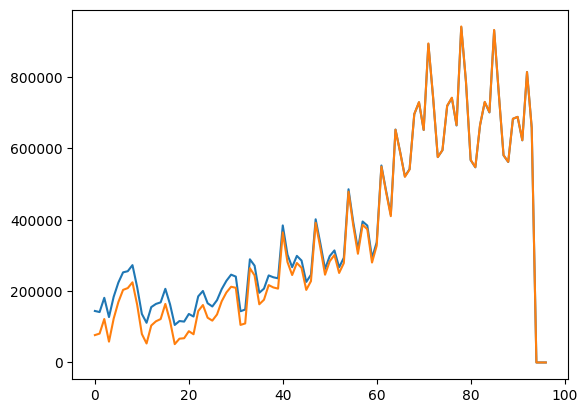

In [ ]:
ri = np.random.randint(0,option_prices.shape[2])
plt.plot(option_prices[:, -1, ri])
plt.plot(spark_spreads[:, -1, ri])

## MtM Computation

We compute the total amount of option prices that the buyer of the contract has at each point in time

In [ ]:
total_option_prices = option_prices.sum(axis=1)

Text(0.5, 1.0, 'Option Prices over time for 5000 scenarios')

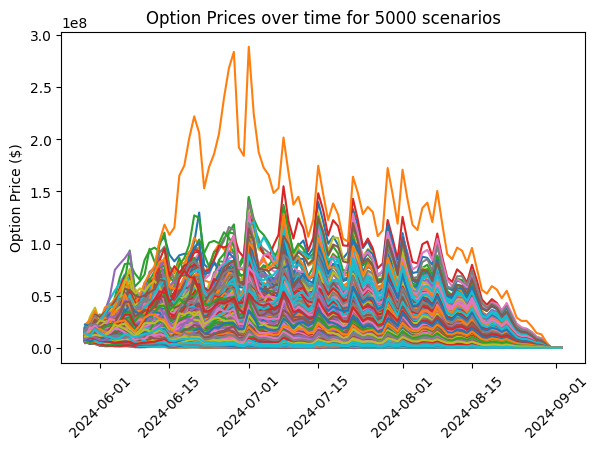

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(pd.DataFrame(total_option_prices, index=simulation_dates))
plt.tight_layout()
plt.xticks(rotation=45)
plt.ylabel("Option Price ($)")
plt.title(f"Option Prices over time for {nb_scenarios} scenarios")

For the contract option premiums, we only account for the monthly payments that haven't been paid, and we need to discount them

In [ ]:
# First, we compute the difference in days between the option premium payment dates and the simulation dates
premium_difference_days = (option_premium_payment_dates.values[np.newaxis, :] - simulation_dates.values[:, np.newaxis]).astype('timedelta64[D]').astype(int).clip(min=0)
premium_difference_days_df = pd.DataFrame(premium_difference_days, index=simulation_dates, columns=option_premium_payment_dates)

# Now we compute the discount factors
premium_discount_factors = np.exp(-interest_rate * premium_difference_days_df.values / 365.25)

# We initialize the matrix of monthly option premium payments
monthly_op_df = pd.DataFrame(monthly_option_premium, index=simulation_dates, columns=option_premium_payment_dates)

# We adjust the first premium to be proportional to the number of remaining days in the first month
monthly_op_df.iloc[0, 0] = monthly_op_df.iloc[0, 0] * (monthly_op_df.columns[1] - premium_difference_days_df.index[0]).days / 30

# Set to 0 the payments that have already been paid
monthly_op_df = monthly_op_df.mask(monthly_op_df.columns.values[np.newaxis, :] < monthly_op_df.index.values[:, np.newaxis], 0)

# Discount the due payments
monthly_op_df_discounted = monthly_op_df * premium_discount_factors

# Sum into one column to account for the total discount payments that are to be done
monthly_op_complete = monthly_op_df_discounted.sum(axis=1)

In [ ]:
monthly_op_complete

2024-05-29    1.544200e+07
2024-05-30    1.494373e+07
2024-05-31    1.494547e+07
2024-06-01    1.494721e+07
2024-06-02    9.948370e+06
                  ...     
2024-08-29    0.000000e+00
2024-08-30    0.000000e+00
2024-08-31    0.000000e+00
2024-09-01    0.000000e+00
2024-09-02    0.000000e+00
Freq: D, Length: 97, dtype: float64

Text(0.5, 1.0, 'Pending discounted Option Premium Payments over time')

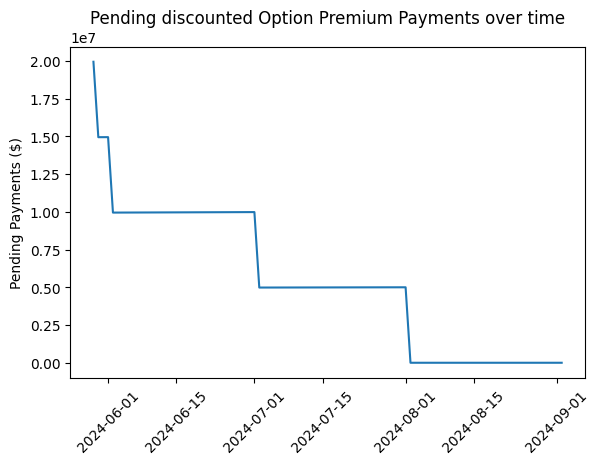

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(pd.DataFrame(monthly_op_complete, index=simulation_dates))
plt.tight_layout()
plt.xticks(rotation=45)
plt.ylabel("Pending Payments ($)")
plt.title(f"Pending discounted Option Premium Payments over time")

Finally, we compute the MtM

In [ ]:
mtm = total_option_prices - monthly_op_complete.values[:, np.newaxis]

Text(0.5, 1.0, 'MtM over time for 5000 scenarios')

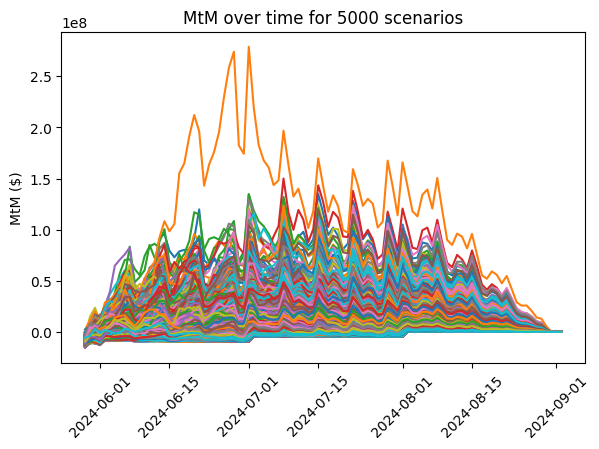

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(pd.DataFrame(mtm, index=simulation_dates))
plt.tight_layout()
plt.xticks(rotation=45)
plt.ylabel("MtM ($)")
plt.title(f"MtM over time for {nb_scenarios} scenarios")

## Extra (currently not used)

Discounting that might prove useful later

Option Discounting

In [ ]:
# # First, we construct the matrix to discount the option prices of the buyer

# option_difference_days = (maturity_dates.values[np.newaxis, :] - simulation_dates.values[:, np.newaxis]).astype('timedelta64[D]').astype(int) / 365.25
# option_discount_factors = np.exp(-interest_rate * option_difference_days).clip(max=1)
# pd.DataFrame(option_discount_factors, index=simulation_dates, columns=maturity_dates)

In [ ]:
# # We discount the prices of HRCO options
# option_prices_discounted = option_prices * option_discount_factors[:, :, np.newaxis]

Option premium discounting

In [ ]:
# # First, we compute the difference in days between the option premium payment dates and the simulation dates
# premium_difference_days = (option_premium_payment_dates.values[np.newaxis, :] - simulation_dates.values[:, np.newaxis]).astype('timedelta64[D]').astype(int).clip(min=0)
# premium_difference_days_df = pd.DataFrame(premium_difference_days, index=simulation_dates, columns=option_premium_payment_dates)

# # Now we compute the discount factors
# premium_discount_factors = np.exp(-interest_rate * premium_difference_days_df.values / 365.25)

# # We initialize the matrix of monthly option premium payments
# monthly_op_df = pd.DataFrame(monthly_option_premium, index=simulation_dates, columns=option_premium_payment_dates)

# # Set to 0 the payments that are not due yet
# monthly_op_df = monthly_op_df.mask(monthly_op_df.columns.values[np.newaxis, :] < monthly_op_df.index.values[:, np.newaxis], 0)

# # Discount the due payments
# monthly_op_df_discounted = monthly_op_df * premium_discount_factors

# # # Now, we extend it so we have a matrix with the same number of columns as the number of simulation dates, and forward-fill since we only do one payment per month
# # premium_difference_days_df_extended = pd.merge(
# #     premium_difference_days_df.T.reset_index(), 
# #     simulation_dates.to_frame().rename(columns={0:"index"}), 
# #     on="index", 
# #     how="right"
# # ).set_index("index").ffill().T
# # # Get only the contract dates as columns
# # premium_difference_days_df_extended.index = pd.to_datetime(premium_difference_days_df_extended.index)
# # premium_difference_days_df_extended = premium_difference_days_df_extended.loc[:, option_premium_payment_dates[0]:option_premium_payment_dates[-1]]

# # # Now we compute the discount factors
# # premium_discount_factors = np.exp(-interest_rate * premium_difference_days_df_extended.values / 365.25)


# # Contrusct the matrix of monthly option premium payments


In [ ]:
# # We initialize the matrix of monthly option premium payments
# monthly_op_df = pd.DataFrame(monthly_option_premium, index=simulation_dates, columns=option_premium_payment_dates)

# # Set to 0 the payments that are not due yet
# monthly_op_df = monthly_op_df.mask(monthly_op_df.columns.values[np.newaxis, :] <= monthly_op_df.index.values[:, np.newaxis], 0)

# # Sum into one column to account for the payments of previous months
# monthly_op_complete = monthly_op_df.sum(axis=1)

# monthly_op_df